## 02807 Computational Tools for Data Science
### Final project - Counter Strike e-Sport data analysis 

Counter-Strike Global Offensive is a game released in 2012, as a sequel to Counter-Strike Source (released in 2004), which is itself a sequel to the original Counter-Strike (released in 2000). The game's longevity is primarily caused by its competitive approach and vibrant professional scene. This longevity has shown in numbers recently, as CS:GO reached in March its all-time high concurrent players (1.1M players), making it the most played game on Steam, 7 years after it was launched. So, I thought it would be interesting to celebrate this milestone by grouping relevant data about the game and seeing what insights people can get from it!

https://www.kaggle.com/datasets/mateusdmachado/csgo-professional-matches/data

In [5]:
#Import Section
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans,DBSCAN
# from matplotlib.animation import FuncAnimation
# import matplotlib
# matplotlib.use("TkAgg")

In [3]:
filepath_player = "data/players.csv"
filepath_match = "data/results.csv"
filepath_picks = "data/picks.csv"
filepath_eco = "data/economy.csv"

df_player = pd.read_csv(filepath_player)
df_match = pd.read_csv(filepath_match)
df_picks = pd.read_csv(filepath_picks)
df_eco = pd.read_csv(filepath_eco, dtype='unicode')

print("DataFrame loaded")

DataFrame loaded


Economy Dataset:

This dataset has 43,234 rows and 99 columns.
Columns include date, match_id, event_id, teams, map, starting sides, and detailed round-by-round economy data for each team (e.g., 1_t1, 2_t1, etc. up to 30 rounds).

Players Dataset:

This dataset wasn't displayed due to its size. I'll provide a detailed analysis of its contents in a separate step.

Results Dataset:

Contains 45,773 rows and 19 columns.
Columns cover details like date, team names, map, round results, map winner, starting side, event ID, match ID, team ranks, map wins, and the match winner.

Picks Dataset:

Comprises 16,035 rows and 17 columns.
Columns include date, team names, match_id, event_id, best of series info, system, maps removed and picked by each team, and the leftover map.

In [3]:
df_player.head()

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,...,m3_kddiff_ct,m3_adr_ct,m3_kast_ct,m3_rating_ct,m3_kills_t,m3_deaths_t,m3_kddiff_t,m3_adr_t,m3_kast_t,m3_rating_t
0,2020-02-26,Brehze,Evil Geniuses,Liquid,United States,9136,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.5,80.0,0.93,7.0,9.0,-2.0,70.4,63.6,0.89
1,2020-02-26,CeRq,Evil Geniuses,Liquid,Bulgaria,11219,2339385,4901,IEM Katowice 2020,3,...,3.0,79.5,53.3,1.12,4.0,8.0,-4.0,40.7,54.5,0.53
2,2020-02-26,EliGE,Liquid,Evil Geniuses,United States,8738,2339385,4901,IEM Katowice 2020,3,...,1.0,81.5,63.6,1.03,9.0,9.0,0.0,87.9,73.3,1.05
3,2020-02-26,Ethan,Evil Geniuses,Liquid,United States,10671,2339385,4901,IEM Katowice 2020,3,...,0.0,67.2,66.7,0.97,1.0,9.0,-8.0,14.8,45.5,0.31
4,2020-02-26,NAF,Liquid,Evil Geniuses,Canada,8520,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.9,81.8,0.96,8.0,7.0,1.0,56.3,80.0,0.99


In [4]:
df_match.head()

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2


In [5]:
df_picks.head()

,date,team_1,team_2,inverted_teams,match_id,event_id,best_of,system,t1_removed_1,t1_removed_2,t1_removed_3,t2_removed_1,t2_removed_2,t2_removed_3,t1_picked_1,t2_picked_1,left_over
0,2020-03-18,TeamOne,Recon 5,1,2340454,5151,3,123412,Vertigo,Train,0.0,Nuke,Overpass,0.0,Dust2,Inferno,Mirage
1,2020-03-18,Rugratz,Bad News Bears,0,2340453,5151,3,123412,Dust2,Nuke,0.0,Mirage,Train,0.0,Vertigo,Inferno,Overpass
2,2020-03-18,New England Whalers,Station7,0,2340461,5243,1,121212,Mirage,Dust2,Vertigo,Nuke,Train,Overpass,0.0,0.0,Inferno
3,2020-03-17,Complexity,forZe,1,2340279,5226,3,123412,Inferno,Nuke,0.0,Overpass,Vertigo,0.0,Dust2,Train,Mirage
4,2020-03-17,Singularity,Endpoint,0,2340456,5247,3,123412,Train,Mirage,0.0,Nuke,Inferno,0.0,Overpass,Vertigo,Dust2


In [6]:
df_eco.head()

,date,match_id,event_id,team_1,team_2,best_of,_map,t1_start,t2_start,1_t1,...,21_winner,22_winner,23_winner,24_winner,25_winner,26_winner,27_winner,28_winner,29_winner,30_winner
0,2020-03-01,2339402,4901,G2,Natus Vincere,5,Nuke,t,ct,4350.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-01,2339402,4901,G2,Natus Vincere,5,Dust2,ct,t,3900.0,...,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN
2,2020-03-01,2339402,4901,G2,Natus Vincere,5,Mirage,t,ct,4150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Dust2,t,ct,4150.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-02-29,2339401,4901,Natus Vincere,Astralis,3,Nuke,ct,t,4200.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1 Team Win retes
Conducts a year-by-year analysis of CS:GO teams' win rates, focusing on those teams that were active throughout the years 2015 to 2020. The final visualization provides an easy-to-understand representation of these trends.

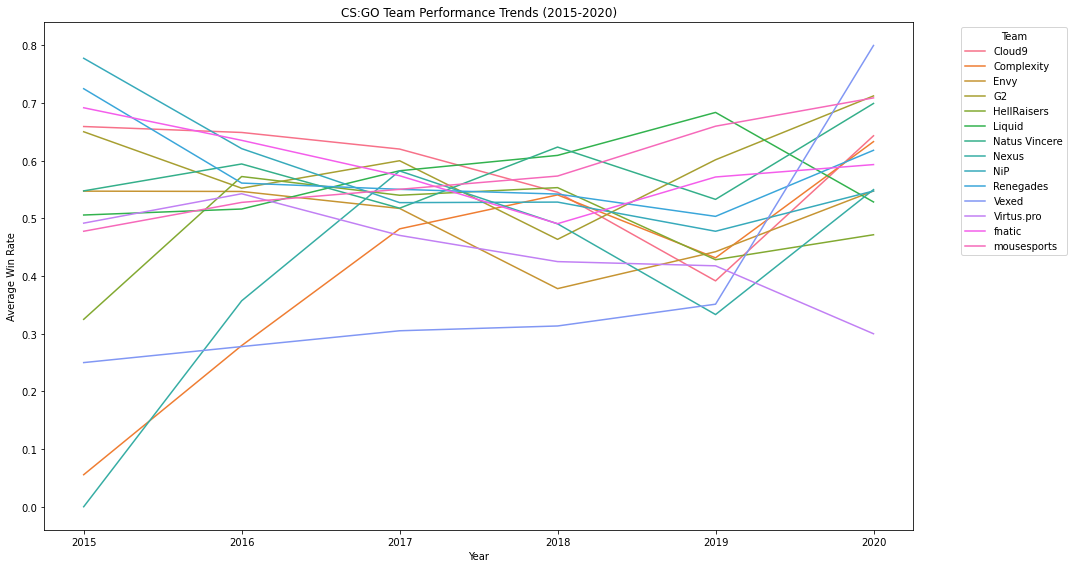

In [7]:
# Convert date to datetime
df_match['date'] = pd.to_datetime(df_match['date'])

# Prepare dataset for team performance analysis
team_performance_df = df_match[['date', 'team_1', 'team_2', 'map_winner', 'event_id', 'match_id']].copy()
team_performance_df['team_1_win'] = team_performance_df['map_winner'] == 1
team_performance_df['team_2_win'] = team_performance_df['map_winner'] == 2
team_performance_df['year'] = team_performance_df['date'].dt.year

# Calculate win rates for each team
team_1_yearly = team_performance_df.groupby(['year', 'team_1']).team_1_win.mean().reset_index()
team_2_yearly = team_performance_df.groupby(['year', 'team_2']).team_2_win.mean().reset_index()
team_1_yearly.rename(columns={'team_1': 'team', 'team_1_win': 'win_rate'}, inplace=True)
team_2_yearly.rename(columns={'team_2': 'team', 'team_2_win': 'win_rate'}, inplace=True)
combined_team_performance = pd.concat([team_1_yearly, team_2_yearly])
average_team_performance = combined_team_performance.groupby(['year', 'team']).win_rate.mean().reset_index()

# Filter teams active from 2015 to 2020
years = list(range(2015, 2021))
teams_active_all_years = average_team_performance.groupby('team').filter(lambda x: all(y in x['year'].values for y in years))

# Plotting the results
plt.figure(figsize=(15, 8))
sns.lineplot(data=teams_active_all_years, x='year', y='win_rate', hue='team')
plt.title('CS:GO Team Performance Trends (2015-2020)')
plt.xlabel('Year')
plt.ylabel('Average Win Rate')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

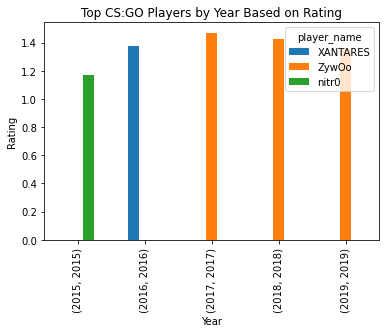

In [8]:
df_player['year'] = pd.to_datetime(df_player['date']).dt.year

# Group by year and player, then count matches and calculate average rating
player_stats = df_player.groupby(['year', 'player_name']).agg({'match_id': 'count', 'rating': 'mean'})

# Filter out players with less than 50 matches per year
player_stats_filtered = player_stats[player_stats['match_id'] > 50]

# For each year, find the top players based on average rating
# Assuming we want the top 1 players each year
top_players_per_year = player_stats_filtered['rating'].groupby('year').nlargest(1)

# Plotting
top_players_per_year.unstack().plot(kind='bar')
plt.title('Top CS:GO Players by Year Based on Rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

## 2Frequent Itemsets:Player combinations

Haocheng

Identify common player combinations in winning teams. If certain players often appear together in winning matches, it might indicate strong team synergy.
 

In [4]:
player_stats = df_player.groupby('player_name').agg({'rating': 'mean', 'match_id': 'count'})

# Filter players who have played more than 50 matches
players_over_matches = player_stats[player_stats['match_id'] > 50]

# Sort by average rating and get the top 10 players
top_10_players = players_over_matches.sort_values(by='rating', ascending=False).head(10)
top_10_players

,rating,match_id
player_name,,
ZywOo,1.395688,327
HuNtR,1.314107,56
XANTARES,1.309018,550
Sico,1.296490,396
vsm,1.295930,172
s1mple,1.293876,485
blameF,1.278400,200
sh1ro,1.276142,127
BnTeT,1.275696,388


In [5]:
# Create a new column for the winning team's name
df_match['winning_team'] = df_match.apply(
    lambda row: row['team_1'] if row['match_winner'] == 1 else row['team_2'], 
    axis=1
)

# Select only the match_id and winning_team columns
winning_teams_df = df_match[['match_id', 'winning_team']]

# Drop duplicates to ensure match_id is unique
winning_teams_df= winning_teams_df.drop_duplicates(subset=['match_id'])
 
winning_teams_df

,match_id,winning_team
0,2340454,TeamOne
2,2340461,Station7
3,2340453,Bad News Bears
5,2340456,Endpoint
7,2340455,Espada
...,...,...
45765,2299057,Vexed
45767,2299059,E-frag.net
45770,2299011,CLG
45771,2299001,NiP


In [7]:
# Merge player and match data
merged_df = pd.merge(df_player, winning_teams_df, on='match_id')


# Calculate win counts for each player
player_win_counts = merged_df['player_name'].value_counts()

# Create a list of players who have more than 10 wins
players_with_more_than_10_wins = player_win_counts[player_win_counts > 10].index.tolist()

# Filter the DataFrame for these players
filtered_winning_teams_df = merged_df[merged_df['player_name'].isin(players_with_more_than_10_wins)]

filtered_winning_teams_df

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,...,m3_adr_ct,m3_kast_ct,m3_rating_ct,m3_kills_t,m3_deaths_t,m3_kddiff_t,m3_adr_t,m3_kast_t,m3_rating_t,winning_team
0,2020-02-26,Brehze,Evil Geniuses,Liquid,United States,9136,2339385,4901,IEM Katowice 2020,3,...,72.5,80.0,0.93,7.0,9.0,-2.0,70.4,63.6,0.89,Liquid
1,2020-02-26,CeRq,Evil Geniuses,Liquid,Bulgaria,11219,2339385,4901,IEM Katowice 2020,3,...,79.5,53.3,1.12,4.0,8.0,-4.0,40.7,54.5,0.53,Liquid
2,2020-02-26,EliGE,Liquid,Evil Geniuses,United States,8738,2339385,4901,IEM Katowice 2020,3,...,81.5,63.6,1.03,9.0,9.0,0.0,87.9,73.3,1.05,Liquid
3,2020-02-26,Ethan,Evil Geniuses,Liquid,United States,10671,2339385,4901,IEM Katowice 2020,3,...,67.2,66.7,0.97,1.0,9.0,-8.0,14.8,45.5,0.31,Liquid
4,2020-02-26,NAF,Liquid,Evil Geniuses,Canada,8520,2339385,4901,IEM Katowice 2020,3,...,72.9,81.8,0.96,8.0,7.0,1.0,56.3,80.0,0.99,Liquid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265380,2015-11-03,Xizt,NiP,Dignitas,Sweden,884,2299001,1934,ESL ESEA Pro League Season 2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NiP
265381,2015-11-03,aizy,Dignitas,NiP,Denmark,8095,2299001,1934,ESL ESEA Pro League Season 2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NiP
265382,2015-11-03,allu,NiP,Dignitas,Finland,695,2299001,1934,ESL ESEA Pro League Season 2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NiP
265383,2015-11-03,f0rest,NiP,Dignitas,Sweden,29,2299001,1934,ESL ESEA Pro League Season 2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NiP


In [19]:
baskets = []
for match_id, group in filtered_winning_teams_df.groupby('match_id'):
    # Filter to keep only players from the winning team
    winning_team_players = group[group['team'] == group['winning_team']]['player_name']
    # Create a basket (set) of unique player names
    basket = list(set(winning_team_players))
    baskets.append(basket)
print(len(baskets))
baskets

26535


[['allu', 'friberg', 'Xizt', 'GeT_RiGhT', 'f0rest'],
 ['allu', 'friberg', 'Xizt', 'GeT_RiGhT', 'f0rest'],
 ['FNS', 'reltuC', 'jdm64', 'tarik', 'hazed'],
 ['fer', 'coldzera', 'FalleN', 'steel', 'boltz'],
 ['adreN', 'FugLy', 'Hiko', 'EliGE', 'nitr0'],
 ['Hyper', 'GruBy', 'Furlan', 'peet', 'rallen'],
 ['bubble', 'v1c7oR', 'dream3r', 'nkl', 'spyleadeR'],
 ['FNS', 'reltuC', 'jdm64', 'tarik', 'hazed'],
 ['fer', 'coldzera', 'FalleN', 'steel', 'boltz'],
 ['NiKo', 'chrisJ', 'nex', 'gob b', 'denis'],
 ['Pimp', 'MSL', 'Kjaerbye', 'TENZKI', 'aizy'],
 ['NiKo', 'chrisJ', 'nex', 'gob b', 'denis'],
 ['Ex6TenZ', 'shox', 'ScreaM', 'RpK', 'SmithZz'],
 ['TaZ', 'byali', 'NEO', 'pashaBiceps', 'Snax'],
 ['Ex6TenZ', 'shox', 'ScreaM', 'RpK', 'SmithZz'],
 ['TaZ', 'byali', 'NEO', 'pashaBiceps', 'Snax'],
 ['TaZ', 'byali', 'NEO', 'pashaBiceps', 'Snax'],
 ['kioShiMa', 'NBK-', 'Happy', 'kennyS', 'apEX'],
 ['fer', 'coldzera', 'FalleN', 'steel', 'boltz'],
 ['freakazoid', 'shroud', 'seang@res', 'Skadoodle', 'n0thing'],

In [10]:
# Ensure all player names are treated as strings and drop any NaN values
filtered_winning_teams_df['player_name'] = filtered_winning_teams_df['player_name'].astype(str).copy()
filtered_winning_teams_df = filtered_winning_teams_df.dropna(subset=['player_name'])

# Extract and sort unique player names
all_players = sorted(filtered_winning_teams_df['player_name'].unique())
len(all_players)
#all_players

2272

In [11]:
df_players_hash = pd.DataFrame(range(len(all_players)), index = list(all_players), columns =['hashcode'], dtype=int)
df_players_hash

,hashcode
0i,0
1962,1
1mpala,2
1uke,3
1ukey,4
...,...
zorte,2267
zpr,2268
zqkS,2269
ztk,2270


In [24]:
item_count_arr = np.zeros((len(all_players),1))

for b in baskets:
    for item in b:
            idx = df_players_hash.loc[item,'hashcode']
            item_count_arr[idx] += 1
            
### find frequent items with support > s1 (here s1 = 0.011), and hash back from array index to items           
freq_items  = [df_players_hash[df_players_hash['hashcode']==x].index[0] for x in np.where(item_count_arr > 0.011*len(baskets))[0]] 
len(freq_items)
#freq_items

65

In [13]:
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items)+1), index=freq_items, columns=['hashcode'])
df_freq_item_hash

,hashcode
ALEX,1
CeRq,2
EliGE,3
Ethan,4
FalleN,5
...,...
stanislaw,61
steel,62
syrsoN,63
tarik,64


In [14]:
pair_mat_hashed = np.zeros((len(freq_items)+1,len(freq_items)+1))

for b in baskets:
    cand_list = [item for item in b if item in freq_items]
    if len(cand_list)<2:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            i = df_freq_item_hash.loc[item1,'hashcode'] 
            j = df_freq_item_hash.loc[item2,'hashcode'] 
            #triangular_arr[triangular_encode(i,j,n)] +=1
            #pair_mat.loc[item1, item2] += 1
            pair_mat_hashed[max(i,j),min(i,j)]+=1

# pair_mat
pair_mat_hashed

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 71., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [15]:
freq_pairs = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0]] for x, y in zip(*np.where(pair_mat_hashed > 0.014*len(baskets)))]
freq_pairs

[['coldzera', 'FalleN'],
 ['device', 'Xyp9x'],
 ['dupreeh', 'Xyp9x'],
 ['dupreeh', 'device'],
 ['fer', 'FalleN'],
 ['fer', 'coldzera'],
 ['nitr0', 'EliGE']]

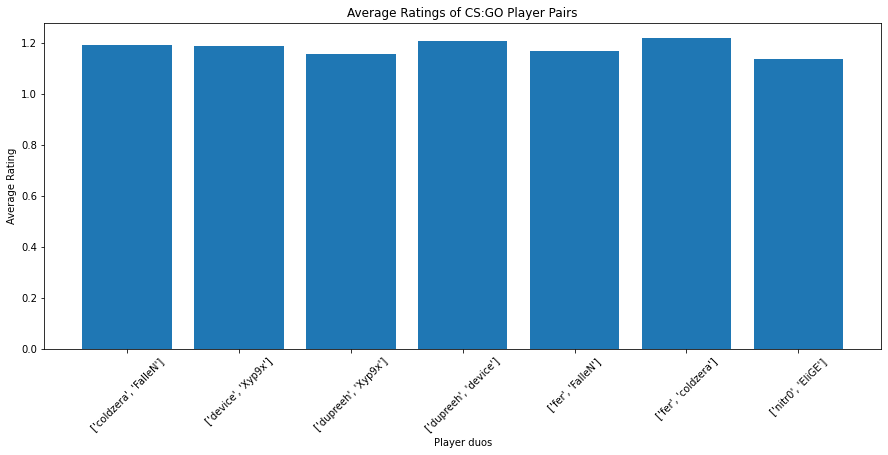

In [18]:
avg_ratings = {}
for pair in freq_pairs:
    # Filter data for matches where both players in the pair played
    pair_df = df_player[df_player['player_name'].isin(pair)]
    # Calculate average rating for the pair
    avg_rating = pair_df['rating'].mean()
    avg_ratings[str(pair)] = avg_rating

# Visualization
plt.figure(figsize=(15, 6))
plt.bar(avg_ratings.keys(), avg_ratings.values())
plt.xlabel('Player duos')
plt.ylabel('Average Rating')
plt.title('Average Ratings of CS:GO Player Pairs')
plt.xticks(rotation=45)
plt.show()

HERE ARE THE BEST DUOS IN CS:GO HISTORY

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.use("TkAgg")

# 3 Huiyu Xie

In [23]:
player_kills = df_player.groupby("player_name")[["kills","assists","deaths","hs","flash_assists","rating"]].mean().apply(lambda x: x)
player_count = df_player.value_counts()
player_kills.dropna()
player_kills.fillna(0, inplace=True)
player_kills

,kills,assists,deaths,hs,flash_assists,rating
player_name,,,,,,
!99,6.500000,2.000000,18.000000,2.500000,0.000000,0.390000
$ally,42.000000,8.000000,37.500000,18.000000,0.000000,1.110000
$h0cK3r,20.000000,1.000000,34.000000,11.000000,1.000000,0.640000
-AtomiK,10.000000,2.000000,17.666667,4.666667,0.000000,0.630000
-Backstab,13.500000,3.000000,27.500000,8.000000,0.000000,0.570000
...,...,...,...,...,...,...
zyoutan,16.000000,4.000000,34.000000,5.000000,0.000000,0.510000
zyp,31.206897,7.172414,36.482759,16.310345,1.392857,0.928276
zypath,35.285714,10.571429,38.714286,9.000000,3.333333,0.922857


In [24]:
kda = player_kills
kda["deaths"] = kda["deaths"].replace(0,1)
player_kills["kda"] = (kda['kills']+kda["assists"]) / kda["deaths"]
player_kills

,kills,assists,deaths,hs,flash_assists,rating,kda
player_name,,,,,,,
!99,6.500000,2.000000,18.000000,2.500000,0.000000,0.390000,0.472222
$ally,42.000000,8.000000,37.500000,18.000000,0.000000,1.110000,1.333333
$h0cK3r,20.000000,1.000000,34.000000,11.000000,1.000000,0.640000,0.617647
-AtomiK,10.000000,2.000000,17.666667,4.666667,0.000000,0.630000,0.679245
-Backstab,13.500000,3.000000,27.500000,8.000000,0.000000,0.570000,0.600000
...,...,...,...,...,...,...,...
zyoutan,16.000000,4.000000,34.000000,5.000000,0.000000,0.510000,0.588235
zyp,31.206897,7.172414,36.482759,16.310345,1.392857,0.928276,1.051985
zypath,35.285714,10.571429,38.714286,9.000000,3.333333,0.922857,1.184502


In [25]:
X = player_kills[["kda","hs","rating"]]
scale = StandardScaler()
x_scale = scale.fit_transform(X)
inertia_values = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_scale)
    inertia_values.append(kmeans.inertia_)
# kmeans = KMeans(n_clusters=k,random_state=69)
# player_kills["cluster"] = kmeans.fit_predict(x_scale)
plt.plot(range(2, 10), inertia_values, marker='o')
plt.draw()
plt.pause(10)
plt.close()

In [26]:
k = 2
kmeans = KMeans(n_clusters=k,random_state=69)
player_kills["cluster"] = kmeans.fit_predict(x_scale)

In [27]:
%matplotlib widget
import matplotlib
matplotlib.use("TkAgg")
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    cluster_points = player_kills[player_kills['cluster'] == cluster]
    ax.scatter(cluster_points["kda"], cluster_points["hs"], cluster_points["rating"], label=f'Cluster {cluster}')

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
           marker='.', s=200, color='red', label='K-Means Center')

ax.set_title('K-means Clustering of Player Performance')
ax.set_xlabel('K/D Ratio')
ax.set_ylabel('Headshot %')
ax.set_zlabel('Rating')

ax.view_init(0, 0)
plt.draw()
plt.pause(60)
plt.close()

In [28]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
player_kills['Cluster'] = dbscan.fit_predict(x_scale)

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in player_kills['cluster'].unique():
    cluster_points = player_kills[player_kills['cluster'] == cluster]
    ax.scatter(cluster_points['kda'], cluster_points['hs'], cluster_points['rating'], label=f'Cluster {cluster}')

ax.set_xlabel('K/D Ratio')
ax.set_ylabel('Headshot %')
ax.set_zlabel('Rating')
ax.set_title('DBSCAN Clustering of Player Performance')
ax.legend()
plt.draw()
plt.pause(60)
plt.close()

## 4 Logistic Regression

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load the dataset
file_path = 'data/results.csv'
data = pd.read_csv(file_path)

In [9]:
# Filter for Astralis matches and create target variable
astralis_data = data[(data['team_1'] == 'Astralis') | (data['team_2'] == 'Astralis')]
astralis_data['astralis_win'] = ((astralis_data['team_1'] == 'Astralis') & (astralis_data['map_winner'] == 1)) | \
                                ((astralis_data['team_2'] == 'Astralis') & (astralis_data['map_winner'] == 2))
astralis_data['astralis_win'] = astralis_data['astralis_win'].astype(int)
astralis_data['opposing_team'] = astralis_data.apply(lambda x: x['team_2'] if x['team_1'] == 'Astralis' else x['team_1'], axis=1)

C:\Users\Bowen\AppData\Local\Temp\ipykernel_28636\1943943165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astralis_data['astralis_win'] = ((astralis_data['team_1'] == 'Astralis') & (astralis_data['map_winner'] == 1)) | \
C:\Users\Bowen\AppData\Local\Temp\ipykernel_28636\1943943165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  astralis_data['astralis_win'] = astralis_data['astralis_win'].astype(int)
C:\Users\Bowen\AppData\Local\Temp\ipykernel_28636\1943943165.py:6: SettingWithCopyWarning: 
A val

In [10]:
# Prepare data for modeling
model_data = astralis_data[['_map', 'opposing_team', 'astralis_win']]
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(model_data[['_map', 'opposing_team']])
X = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['_map', 'opposing_team']))
y = model_data['astralis_win'].values

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
# Retrieve the unique maps and teams from the original dataset
unique_maps = astralis_data['_map'].unique()
unique_opponents = astralis_data['opposing_team'].unique()

In [14]:
# Create a DataFrame with all combinations of maps and opponents
from itertools import product
map_team_combinations = pd.DataFrame(list(product(unique_maps, unique_opponents)), columns=['_map', 'opposing_team'])


In [15]:
# Encode the combinations using the same encoder used for the model
encoded_combinations = encoder.transform(map_team_combinations)


In [16]:
# Predict the probability of Astralis winning for each combination
predicted_probabilities = log_reg.predict_proba(encoded_combinations)[:, 1]

C:\Users\Bowen\Software 6th\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [17]:
# Add the predicted probabilities back to the combinations DataFrame
map_team_combinations['predicted_probability'] = predicted_probabilities

In [18]:
# Display the DataFrame sorted by probability of Astralis winning
map_team_combinations.sort_values(by='predicted_probability', ascending=False).reset_index(drop=True)

,_map,opposing_team,predicted_probability
0,Nuke,CLG,0.923089
1,Inferno,CLG,0.919799
2,Overpass,CLG,0.903392
3,Vertigo,CLG,0.896645
4,Nuke,100 Thieves,0.889163
...,...,...,...
589,Cobblestone,G2,0.231201
590,Cobblestone,Natus Vincere,0.205872
591,Cobblestone,Luminosity,0.196938
592,Cobblestone,X,0.162137


In [19]:
# Predict and evaluate on the test set
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)


In [20]:
# Generate evaluation metrics and plots
conf_matrix = confusion_matrix(y_test, y_pred > 0.5)
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
feature_importance = abs(log_reg.coef_[0])
sorted_idx = np.argsort(feature_importance)

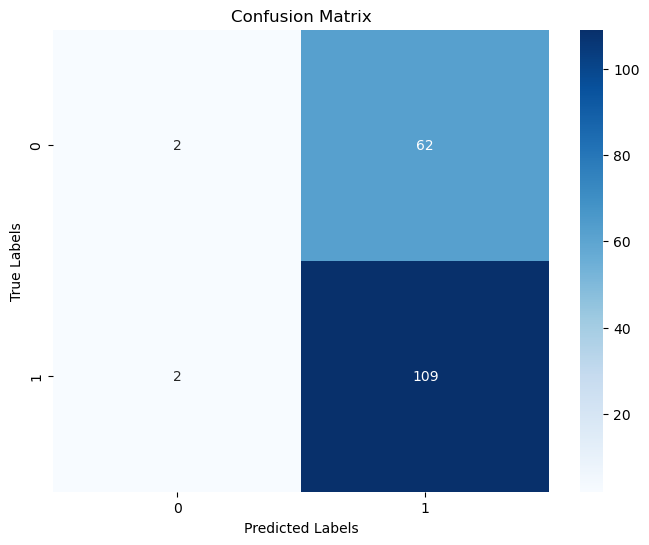

In [21]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


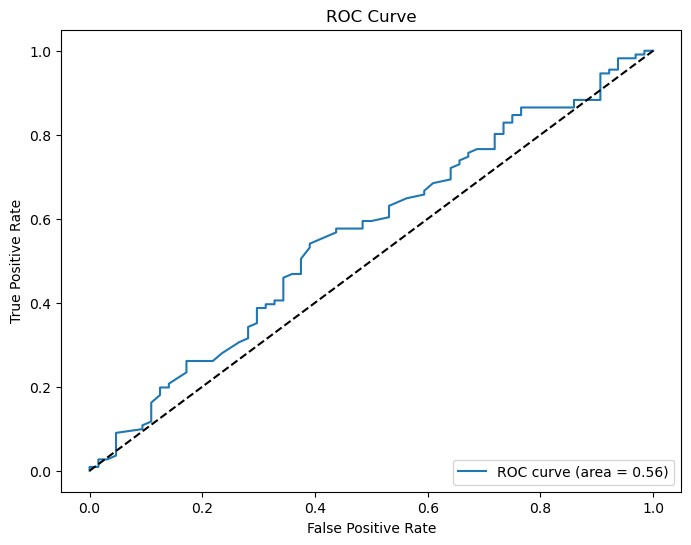

In [22]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

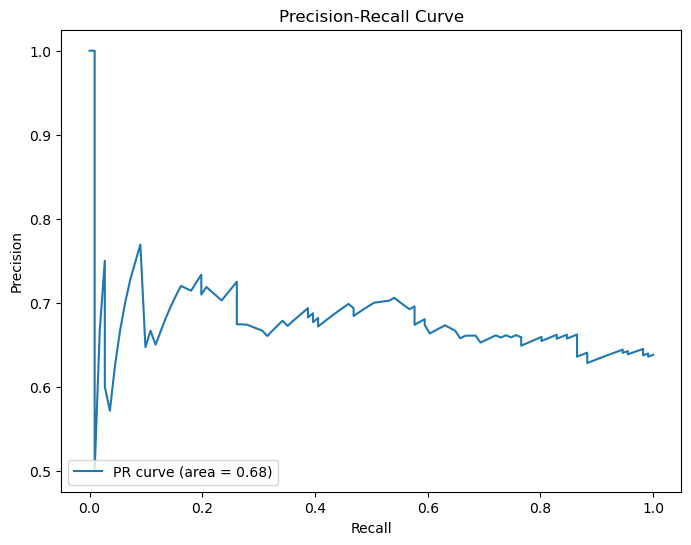

In [23]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


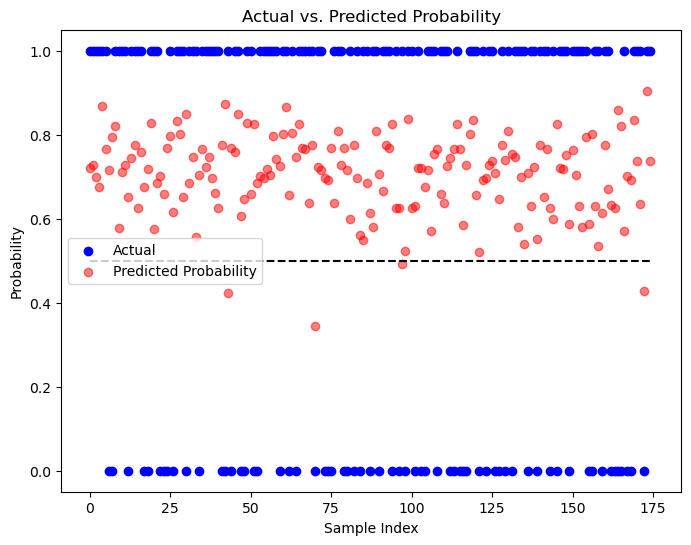

In [24]:
# Actual vs. Predicted Probability
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred_prob)), y_pred_prob, color='red', alpha=0.5, label='Predicted Probability')
plt.plot([0, len(y_test)], [0.5, 0.5], 'k--')
plt.title('Actual vs. Predicted Probability')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [25]:
accuracy = accuracy_score(y_test, y_pred)
# Print the accuracy of the model
print(f"The accuracy of the logistic regression model is: {accuracy:.2f}")

The accuracy of the logistic regression model is: 0.63
